# MNIST

### MNIST 데이터 받기

In [1]:
import os
import sys
from six.moves import urllib
import gzip
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


SOURCE_URL = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
FILENAME = SOURCE_URL.split('/')[-1]
DATA_DIR = './datasets'

def maybe_download(data_dir):
    filepath = os.path.join(data_dir, FILENAME)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.isfile(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading {} {:.1f} %'.format(
                FILENAME, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully donloaded', FILENAME, statinfo.st_size, 'bytes.')

def load(data_dir, subset='train'):
    maybe_download(data_dir)
    filepath = os.path.join(data_dir, FILENAME)
    
    f = gzip.open(filepath, 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()
    f.close()
    
    if subset == 'train':
        trainx, trainy = train_set
        trainx = trainx.astype(np.float32).reshape(trainx.shape[0], 28, 28)
        trainy = trainy.astype(np.uint8)
        return trainx, trainy
    elif subset == 'test':
        testx, testy = test_set
        testx = testx.astype(np.float32).reshape(testx.shape[0], 28, 28)
        testy = testy.astype(np.uint8)
        return testx, testy
    elif subset== 'valid':
        validx, validy = valid_set
        validx = validx.astype(np.float32).reshape(validx.shape[0], 28, 28)
        validy = validy.astype(np.uint8)
        return validx, validy
    else:
        raise NotImplementedError('subset should be train or valid or test')

# Load data
train_data, train_label = load(DATA_DIR, 'train')
valid_data, valid_label = load(DATA_DIR, 'valid')
test_data, test_label = load(DATA_DIR, 'test')

# concatenate train and valid data as train data
train_data = np.concatenate((train_data, valid_data))
train_label = np.concatenate((train_label, valid_label))

### MNIST 데이터 확인 하기

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


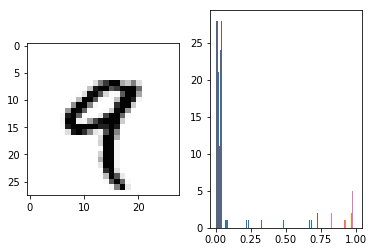

In [3]:
# show data
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[4]
ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax2.hist(sample_data, bins=20, range=[0, 1]);

In [4]:
import tensorflow as tf

In [5]:
learning_rate = 1e-3
num_epochs = 100
batch_size = 100 # 한 에폭마다 셔플 후 128개를(2^n)개 샘플링 해야 정석!
num_display = 100

def get_model(X,by):
    X = tf.expand_dims(X, axis=3) #3차원으로 늘린다 (None,28,28) 
    
    with tf.variable_scope('first',reuse=tf.AUTO_REUSE):
        outs = tf.layers.conv2d(X, 128, 3, padding='same') # 일반적인 CNN은 크기를 줄이지 않기 때문에 패딩을 넣는다.
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs,2,2)
        
    with tf.variable_scope('second',reuse=tf.AUTO_REUSE):
        outs = tf.layers.conv2d(outs, 256, 3, padding='same')
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs,2,2)
        
    with tf.variable_scope('third',reuse=tf.AUTO_REUSE):
        outs = tf.layers.conv2d(outs, 64, 3, padding='same')
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs,2,2)
    
    outs = tf.reshape(outs, (-1, outs.shape[1]*outs.shape[2]*outs.shape[3]))
    outs = tf.layers.dense(outs, 128)
    outs = tf.nn.relu(outs)
    outs = tf.layers.dense(outs, 10)
    
    one_hot = tf.one_hot(by, 10)
    
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=outs,labels=one_hot)
    loss = tf.reduce_mean(loss)
    
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    preds = tf.cast(tf.argmax(tf.nn.softmax(outs),axis = 1), tf.int32)
    
    acc = tf.reduce_mean(tf.cast(tf.equal(by,preds), tf.float32))
    init = tf.global_variables_initializer()
    
    return {'loss':loss, 'opt':opt, 'preds':preds, "acc":acc, 'init': init}

In [6]:
X = tf.placeholder(tf.float32, shape=(None,28,28))
by = tf.placeholder(tf.int32)

model = get_model(X,by)

In [7]:
with tf.Session() as sess:
    sess.run(model['init'])
    for ind_epoch in range(0, num_epochs):
        print('Current iteration {}'.format(ind_epoch +1))
        
        for ind_ in range(0, int(60000 / batch_size)):
            batch_X = train_data[ind_*batch_size:(ind_+1)*batch_size]
            batch_by = train_label[ind_*batch_size:(ind_+1)*batch_size]
            
            _, cur_loss, cur_acc = sess.run([model['opt'], model['loss'], model['acc']],
                                            feed_dict={X:batch_X, by: batch_by})
            
            if ind_ % num_display == 0:
                print('loss {0:.4f} acc {1:.4f}'.format(cur_loss, cur_acc))
    
    cur_acc_all = 0.0
    cur_loss_all = 0.0
    
    for ind_ in range(0,10):
        cur_loss, cur_acc = sess.run([model['loss'], model['acc']],
                                      feed_dict={X:test_data, by: test_label})
            
        print('Test: loss {0:.4f} Test: acc {1:.4f}'.format(cur_loss, cur_acc))
    

Current iteration 1
loss 2.2999 acc 0.1300
loss 0.2089 acc 0.9200
loss 0.1365 acc 0.9500
loss 0.0640 acc 0.9800
loss 0.0443 acc 0.9900
loss 0.0467 acc 0.9800
Current iteration 2
loss 0.0335 acc 0.9900
loss 0.0496 acc 0.9900
loss 0.0491 acc 0.9700
loss 0.0729 acc 0.9900
loss 0.0290 acc 0.9900
loss 0.0078 acc 1.0000
Current iteration 3
loss 0.0416 acc 0.9900
loss 0.0184 acc 0.9900
loss 0.0423 acc 0.9900
loss 0.0595 acc 0.9900
loss 0.0202 acc 0.9900
loss 0.0030 acc 1.0000
Current iteration 4
loss 0.0064 acc 1.0000
loss 0.0208 acc 0.9900
loss 0.0269 acc 0.9900
loss 0.0343 acc 0.9900
loss 0.0015 acc 1.0000
loss 0.0039 acc 1.0000
Current iteration 5
loss 0.0072 acc 1.0000
loss 0.0064 acc 1.0000
loss 0.0177 acc 0.9900
loss 0.0384 acc 0.9900
loss 0.0034 acc 1.0000
loss 0.0004 acc 1.0000
Current iteration 6
loss 0.0126 acc 1.0000
loss 0.0179 acc 0.9900
loss 0.0124 acc 1.0000
loss 0.0153 acc 1.0000
loss 0.0044 acc 1.0000
loss 0.0022 acc 1.0000
Current iteration 7
loss 0.0024 acc 1.0000
loss 0.01

loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
Current iteration 53
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
Current iteration 54
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
Current iteration 55
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
Current iteration 56
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
Current iteration 57
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
Current iteration 58
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000
loss 0.0000 acc 1.0000


ResourceExhaustedError: OOM when allocating tensor with shape[10000,128,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node first/conv2d/Conv2D (defined at <ipython-input-5-4a1382ccb27d>:10)  = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](first/conv2d/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, first/conv2d/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node Mean/_27}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_109_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'first/conv2d/Conv2D', defined at:
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-6c8b1b2a71e7>", line 4, in <module>
    model = get_model(X,by)
  File "<ipython-input-5-4a1382ccb27d>", line 10, in get_model
    outs = tf.layers.conv2d(X, 128, 3, padding='same') # 일반적인 CNN은 크기를 줄이지 않기 때문에 패딩을 넣는다.
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 417, in conv2d
    return layer.apply(inputs)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 757, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/keras/layers/convolutional.py", line 194, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    name=self.name)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 957, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/pirl/anaconda3/envs/TF/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,128,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node first/conv2d/Conv2D (defined at <ipython-input-5-4a1382ccb27d>:10)  = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](first/conv2d/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, first/conv2d/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node Mean/_27}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_109_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

